<a href="https://colab.research.google.com/github/LeonardoHoltz/MachineLearningDiabetesPredict/blob/main/Trabalho_de_Aprendizado_de_M%C3%A1quina_Classifica%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nosso trabalho tem como objetivo desenvolver um modelo baseado em aprendizado de máquina para prever o diagnóstico de diabetes em mulheres a partir de um conjunto de informações médicas sobre pacientes. Para tanto, utilizamos o conjunto de dados do National Institute of Diabetes and Digestive and Kidney Diseases que contém medições de diagnóstico e informações de mulheres, com mais de 21 anos, pertencente aos pimas, um povo nativo americano. Este conjunto foi usado em um estudo sobre ADAP Learning de Smith et al. (1988) e está disponível em https://www.kaggle.com/datasets/whenamancodes/predict-diabities para download.

## Atributos
Há um total de 8 atributos no conjunto de dados, todos referentes a informações médicas:

- Pregnancies: Quantas vezes que a paciente engravidou;

- Glucose: Glicemia medida por meio de um teste de curva glicemica de 2 horas (provavelmente em mg/dL).

- BloodPressure: Pressão arterial diastólica (mmHg);

- SkinThickness: Espessura da pele medida por meio de uma dobra cutânea do triceps(mm);

- Insulin: Nível de insulina no corpo após 2 horas de aplicação de soro (μU/ml);

- BMI: Índice de massa corporal (kg/m²);

- DiabetesPedigreeFunction: Função criada pelos autores Smith et al. (1988) que fornece uma medida da influência genética para o risco de diabetes em um indivíduo. Quanto maior o número, maior a chance da pessoa possivelmente desenvolver diabetes.

- Age: Idade

Vale lembrar que todos os atributos presentes são númericos, o que pode impactar significantemente nos algoritmos usados no modelo final.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score

sns.set()

# Instâncias

O dataset possui um total de 768 instâncias, sem duplicatas, e com todos os atributos preenchidos. Não é necessário fazer pré-processamento dos dados.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/LeonardoHoltz/MachineLearningDiabetesPredict/main/diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [ ]:
df.drop_duplicates(keep=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


# Distribuição de valores por atributo

## Atributo Alvo

A partir da distribuição, podemos notar que o dataset é levemente desbalanceado. A classe negativa é a predominante no conjunto de dados, presente em 65.1% das instâncias. A partir disso, devemos tomar cuidado em estratificar bem os dados na hora de construir nosso modelo e usar métricas de desempenho efetivas para dados desbalanceados. 

In [ ]:
def plot_target_dist_percentual(df_vc, total):
  """
  Defines a plot figure with a histogram, showing how many rows exists for each class
  and the percentual distribution of each class in the dataset.
  """
  sns.set_context("notebook", font_scale=2)
  sns.set_palette("deep")
  plt.figure(figsize=(8, 9))
  ax = sns.barplot(x=df_vc.index, y=df_vc.values)
  for p in ax.patches:
      percentage = '{:.1f}%'.format(100 * p.get_height()/total)
      x = p.get_x() + (p.get_width() / 2)
      y = p.get_height()
      ax.annotate(percentage, (x, y),ha='center')
  plt.xlabel("Classes")
  plt.ylabel("Rows")
  plt.suptitle("Target column distribution")
  plt.show()

Dataset has 268 instances of the positive class and has 500 instances of the negative class.


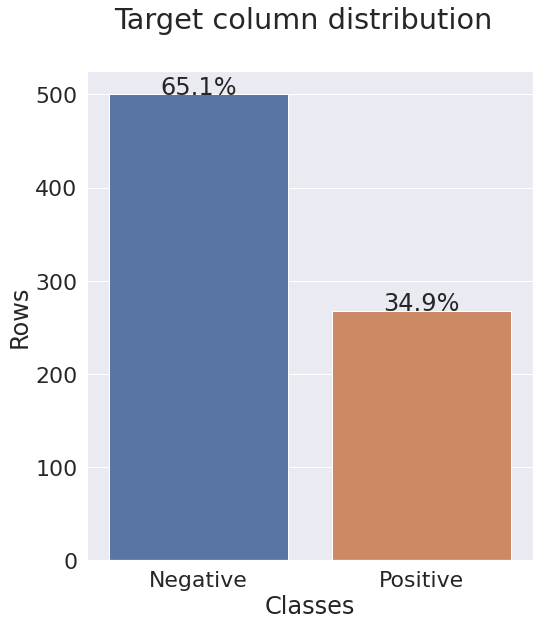

In [ ]:
## Target column distribution

# First, let's copy the dataframe, renaming the target values to 'Positive' and 'Negative' to a better data visualization
df_vis = df.copy(deep=True)
df_vis['Outcome'].replace([0, 1], ['Negative', 'Positive'], inplace=True)

df_vc = df_vis['Outcome'].value_counts()
negative_instances = df_vc[0]
positive_instances = df_vc[1]
total = negative_instances + positive_instances

print(f"Dataset has {positive_instances} instances of the positive class and has {negative_instances} instances of the negative class.")

plot_target_dist_percentual(df_vc, total)

## Outros atributos
Ao analisar os atributos do conjunto de dados e suas variações entre as classes negativa e positiva, podemos inferir atributos que podem ser decisivos na tomada de decisão dos nossos algoritmos, baseado na diferença entre suas distribuições e variações.

A maioria dos atributos possuem valores maiores na classe positiva. Em especial, os atributos *Glucose* e *BloodPressure* são os que mais se diferenciam entre as classes, o que faz sentido, dados os sintomas encontrados em pacientes com Diabetes.

É possível notar também uma quantidade considerável de *outliers* nos dados. É importante que o nosso modelo possa beneficiar-se dos atributos onde existe uma maior diferença na distribuição dos dados, mas que principalmente seja genérico e não se baseie nos *outliers* para classificar novos dados.

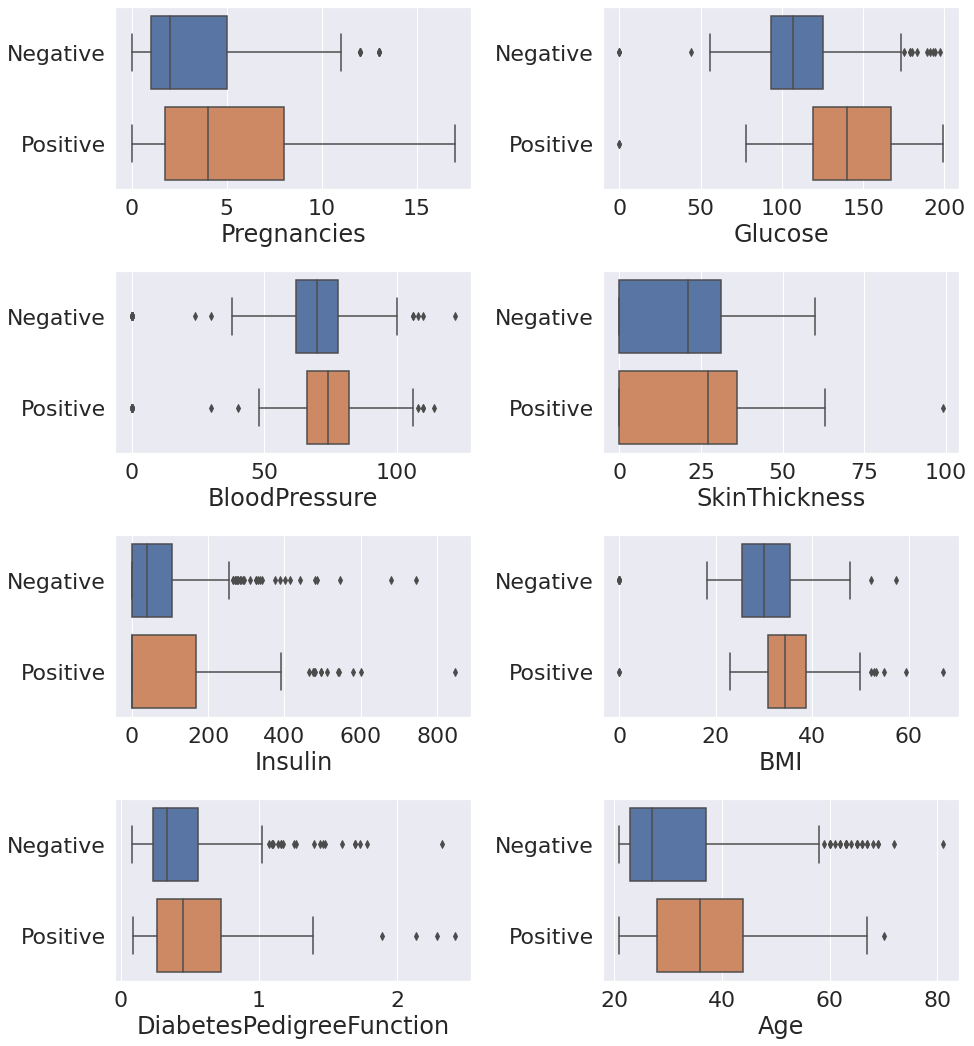

In [ ]:
## Check distribution in each other column
def columns_box_plot(df, columns, label):
    plt.figure(figsize=(14, 15))
    sns.set_context("notebook", font_scale=2)
    sns.set_palette("deep")
    for idx, var in enumerate(columns):
        plt.subplot(4, 2, idx+1)
        g = sns.boxplot(data=df, x=var, y=label, order=['Negative', 'Positive'])
        plt.ylabel('')
    plt.tight_layout(pad=1)


columns_box_plot(df_vis, df_vis.columns[:8], 'Outcome')

# Normalização dos dados

Como nossos dados possuem atributos que variam muito de escala, devemos normalizar os dados, pois alguns dos algoritmos que utilizaremos são sensíveis a mudanças na escala.

In [ ]:
# Normalization maxmin: (value - min / max -min)
normalized_df=(df-df.min())/(df.max()-df.min())

# The normalization sets the last column as a float type, this changes it back to int
normalized_df['Outcome'] = df['Outcome'].astype(int)
normalized_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,0.483333,1
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,0.166667,0
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,0.183333,1
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,0.000000,0
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,0.200000,1
...,...,...,...,...,...,...,...,...,...
763,0.588235,0.507538,0.622951,0.484848,0.212766,0.490313,0.039710,0.700000,0
764,0.117647,0.613065,0.573770,0.272727,0.000000,0.548435,0.111870,0.100000,0
765,0.294118,0.608040,0.590164,0.232323,0.132388,0.390462,0.071307,0.150000,0
766,0.058824,0.633166,0.491803,0.000000,0.000000,0.448584,0.115713,0.433333,1


K-cross validation Mario

In [ ]:
from sklearn import model_selection
class CrossValidationML():
    """
    Implementação com SKlearn, só pra validar o resto do trabalho. 
    """
    def __init__(self, k, df, model_fn, shuffle=True, random_state=2):
        self.k = k
        self.shuffle = True
        self.seed = random_state
        self.df = df

        x = self.df.drop("Outcome", axis=1)
        y = self.df["Outcome"]


        skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)

        for train_index, test_index in skf.split(x, y):
            print(train_index, test_index)
            #x_train_fold, x_test_fold = x[train_index], x[test_index]
            #y_train_fold, y_test_fold = y[train_index], y[test_index]


            #r = model_fn.fit(x_train_fold, y_train_fold)
            #print("Result: ", r)


In [ ]:
clf = RandomForestClassifier()

kfcv = CrossValidationML(5, normalized_df, clf)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  14  16  19  21  22
  23  24  25  26  27  28  29  30  31  36  37  38  39  44  45  46  47  50
  51  54  55  56  57  58  59  60  61  64  66  67  68  70  71  72  73  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 104 106 107 109 110 111 112 113 115 116
 118 119 120 122 123 124 126 127 128 129 130 131 133 134 135 136 137 138
 139 140 141 142 144 145 147 148 150 151 152 153 154 156 157 158 159 161
 162 163 164 165 166 167 168 169 170 171 172 174 175 176 178 179 180 181
 182 183 185 187 189 190 192 195 197 198 199 200 201 202 203 204 206 207
 208 210 211 215 218 220 221 222 224 225 226 227 228 229 230 231 232 234
 235 236 237 238 239 240 242 243 244 245 246 247 248 249 250 251 252 253
 254 255 256 257 258 259 260 261 262 263 265 266 268 269 271 272 273 274
 275 276 277 278 279 280 281 283 284 286 287 288 289 293 294 295 296 297
 298 300 301 302 303 306 307 308 309 310 311 312 31

# Teste com Random Forests

In [ ]:
X = normalized_df.drop("Outcome", axis=1)
y = normalized_df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.7402597402597403


# Referencias
Smith JW, Everhart JE, Dickson WC, Knowler WC, Johannes RS. Using the ADAP Learning Algorithm to Forecast the Onset of Diabetes Mellitus. Proc Annu Symp Comput Appl Med Care. 1988 Nov 9:261–5. PMCID: PMC2245318.

